# Keyword to surrounding text correlation study
- AHREFS interview assignment Q2
- (c) Adarsh Janakiraman
- Sept 2017

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import operator
import common_funcs as com
%matplotlib inline
import sys
reload(sys)
sys.setdefaultencoding('utf8')

In [2]:
# Read the pickles
df_toppages = pd.read_pickle('backlinko_toppages.pkl')
df_backlinks = pd.read_pickle('backlinko_backlinks.pkl')

In [3]:
df_backlinks['surrounding'] = df_backlinks.apply(lambda row: row['text_pre'] + ' ' + row['text_post'], axis=1)

In [4]:
df_joined = pd.merge(df_toppages, df_backlinks[['toppage_url','surrounding']], left_on='URL',right_on='toppage_url')
df_joined.drop_duplicates(inplace=True)

In [8]:
df_keywords = df_joined[['Keyword','surrounding','Position']].copy()
df_keywords['Keyword'] = df_keywords['Keyword'].apply(lambda x: com.remove_stopwords(com.remove_punctuations(string.lower(x))))
df_keywords['surrounding'] = df_keywords['surrounding'].apply(lambda x: com.remove_stopwords(com.remove_punctuations(string.lower(x))))
df_keywords.head()

Keyword                                        surrounding  \
0   website traffic                                                      
3   website traffic  onboarding email simply asks new subscribers t...   
6   website traffic  goals many include customer engagement ultimat...   
7   website traffic  visitors per month opgeroepen op maart 4 2016 ...   
10  website traffic  qualified except maybe matt cutts brian dean n...   

    Position  
0          6  
3          6  
6          6  
7          6  
10         6

In [10]:
df_keywords['exact_match'] = (df_keywords['Keyword'] == df_keywords['surrounding']).astype(int)
df_keywords['phrase_match'] = df_keywords.apply(lambda row: com.phrase_match(row['Keyword'],row['surrounding']), axis=1)
df_keywords.head()

Keyword                                        surrounding  \
0   website traffic                                                      
3   website traffic  onboarding email simply asks new subscribers t...   
6   website traffic  goals many include customer engagement ultimat...   
7   website traffic  visitors per month opgeroepen op maart 4 2016 ...   
10  website traffic  qualified except maybe matt cutts brian dean n...   

    Position  exact_match  phrase_match  
0          6            0             0  
3          6            0             0  
6          6            0             0  
7          6            0             0  
10         6            0             0

In [11]:
sns.set_style('ticks')
sns.boxplot('exact_match','Position',data=df_keywords)
plt.xlabel('Exact match')
plt.ylabel('Google search rank')
plt.title('Exact match (Keyword-Anchor) vs. Google search rank')
sns.despine()

In [12]:
sns.set_style('ticks')
sns.boxplot('phrase_match','Position',data=df_keywords)
plt.xlabel('Phrase match')
plt.ylabel('Google search rank')
plt.title('Phrase match (atleast one) vs. Google search rank')
sns.despine()

In [13]:
def build_regplots(df, col, colname, aggfunc='mean', save_file_name = ''):
    import scipy
    tmp = (df.groupby(['Position'])[col].agg(aggfunc)*100)
    x_vals = tmp.index.values
    y_vals = tmp
    slope, intercept, r_value, p_value, std_err \
                = scipy.stats.linregress(x=x_vals ,y=y_vals)
    r_squared = r_value**2
    sns.regplot(tmp.index.values, tmp)
    sns.despine()
    plt.xticks(range(0,11,1))
    plt.ylabel(colname)
    plt.xlabel('Google search rank')
    plt.title('Y = {0} - {1}x ; $R^2$ = {2}'.format(round(intercept,2), abs(round(slope,2)), round(r_squared,3)))
    if save_file_name:
        plt.savefig(save_file_name)
    plt.show();

In [14]:
build_regplots(df_keywords, 'phrase_match','% keywords with Phrase Match', save_file_name='figs/surrounding_phrase_match_full.png')

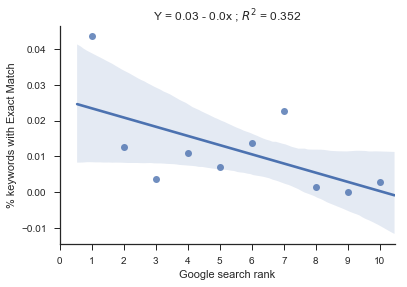

In [15]:
build_regplots(df_keywords, 'exact_match','% keywords with Exact Match', save_file_name='figs/surrounding_exact_match_full.png' )

In [16]:
df_keywords['surrounding_brand'] = df_keywords['surrounding'].str.contains('backlinko').astype(int)
df_keywords['keyword_missing'] = 1-df_keywords[['exact_match','phrase_match']].apply(max, axis=1)
df_keywords['keyword_missing_w_surrounding'] = 1-df_keywords[['exact_match','phrase_match','surrounding_brand']].apply(max, axis=1)

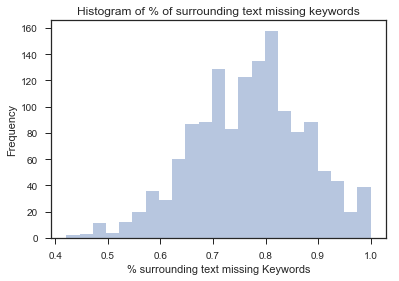

In [17]:
sns.distplot((df_keywords.groupby(['Keyword'])['keyword_missing'].mean()), kde=False, axlabel='% surrounding text missing Keywords')
plt.ylabel('Frequency')
plt.title('Histogram of % of surrounding text missing keywords')
plt.savefig('figs/surrounding_keyword_missing_anchor_text.png')
plt.show()

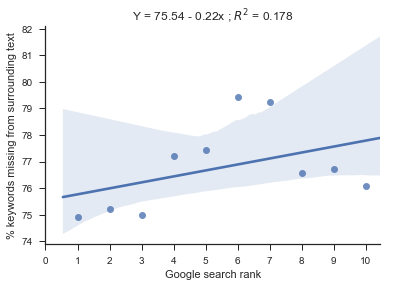

In [18]:
build_regplots(df_keywords, 'keyword_missing','% keywords missing from surrounding text', save_file_name='figs/surrounding_keyword_missing_full.png')

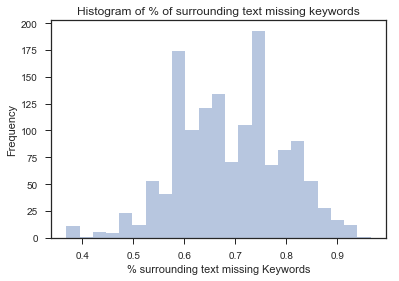

In [19]:
sns.distplot((df_keywords.groupby(['Keyword'])['keyword_missing_w_surrounding'].mean()), kde=False, axlabel='% surrounding text missing Keywords')
plt.ylabel('Frequency')
plt.title('Histogram of % of surrounding text missing keywords')
plt.savefig('figs/surrounding_keyword_missing_anchor_text.png')
plt.show()

In [20]:
df_keywords['surrounding_text_length'] = df_keywords['surrounding'].apply(lambda x: len(x.split()))
df_keywords['keyword_text_length'] = df_keywords['Keyword'].apply(lambda x: len(x.split()))

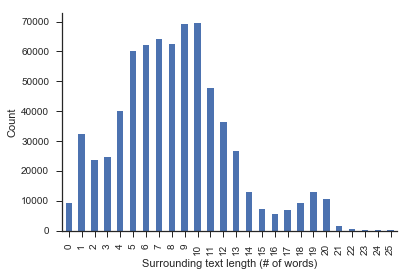

In [21]:
df_keywords.groupby(['surrounding_text_length']).size().plot('bar')
sns.despine()
plt.xlabel('Surrounding text length (# of words)')
plt.ylabel('Count')
plt.savefig('figs/surrounding_text_length_dist.png')

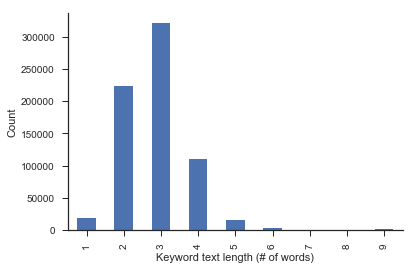

In [22]:
df_keywords.groupby(['keyword_text_length']).size().plot('bar')
sns.despine()
plt.xlabel('Keyword text length (# of words)')
plt.ylabel('Count')
plt.savefig('figs/keyword_text_length_dist.png')

In [23]:
df_keywords.to_pickle('keywords_surrounding_q2.pkl')